
<h3 align=center>GAN NETWORK & DCGAN


Producing synthetic data takes its place at the top of the list of studies on artificial intelligence. In addition to producing data similar to a data, it can also produce visual, auditory and written works of art. We can also produce human faces that you cannot distinguish from the real thing. We can also imitate an artist's style. It can also be used to ensure that the data you will need in the medical field is reproduced by making use of the existing ones. All this is possible with the successful removal of patterns.

Deep generative networks are not just GANs! I found different approaches such as Boltzmann machine approaches, Deep Belif Networks, Convolutional Boltzmann approaches, Directed Generative Nets and Variational Autoencoders were before and still used in GANs. [*](https://www.deeplearningbook.org/contents/generative_models.html)

 ![GAN Fake Face](https://wp.technologyreview.com/wp-content/uploads/2021/10/Cube_fake-to-real-2a-feed.gif?fit=1616,908) </h3>


### Performing operations on GPU


While working in Google Colab, training the tutorials on the GPU or on the TPU will make a difference in time.


In [1]:
#Authentication process to use GPU
from google.colab import drive
drive.mount('/gdrive')
#%cd /gdrive

Mounted at /gdrive


In [2]:
!ls "/gdrive/My Drive/deep_learning/"

keras


In [3]:
import os
os.chdir("/gdrive/My Drive/deep_learning/")

In [4]:
#You can see the hardware features you will use by running this piece of code.
import tensorflow as tf
tf.test.gpu_device_name()
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 8844717823359492166
 xla_global_id: -1]

### GAN
Variational autoencoders (VAEs) have been one of the exciting topics of artificial intelligence since 2014. and Generative adverserial networks (GANs), it becomes possible to change the existing image or to produce a new one by sampling the hidden space in the images. The GAN approach, which shook the world of deep learning with Ian Goodfellow, paves the way for the production of synthetic data that cannot be distinguished from the real in statistical terms. In the working structure, he may initially be thought of as a bad imitator. The ability to imitate gradually develops and new outputs are produced that are indistinguishable from the real, but not identical.


[Essential resource for GAN](https://arxiv.org/pdf/1406.2661.pdf)

In this work file, I am trying to show the logic of the subject by considering DCGAN, that is, a convolutional GAN ​​type. The figure below represents a basic GAN structure.

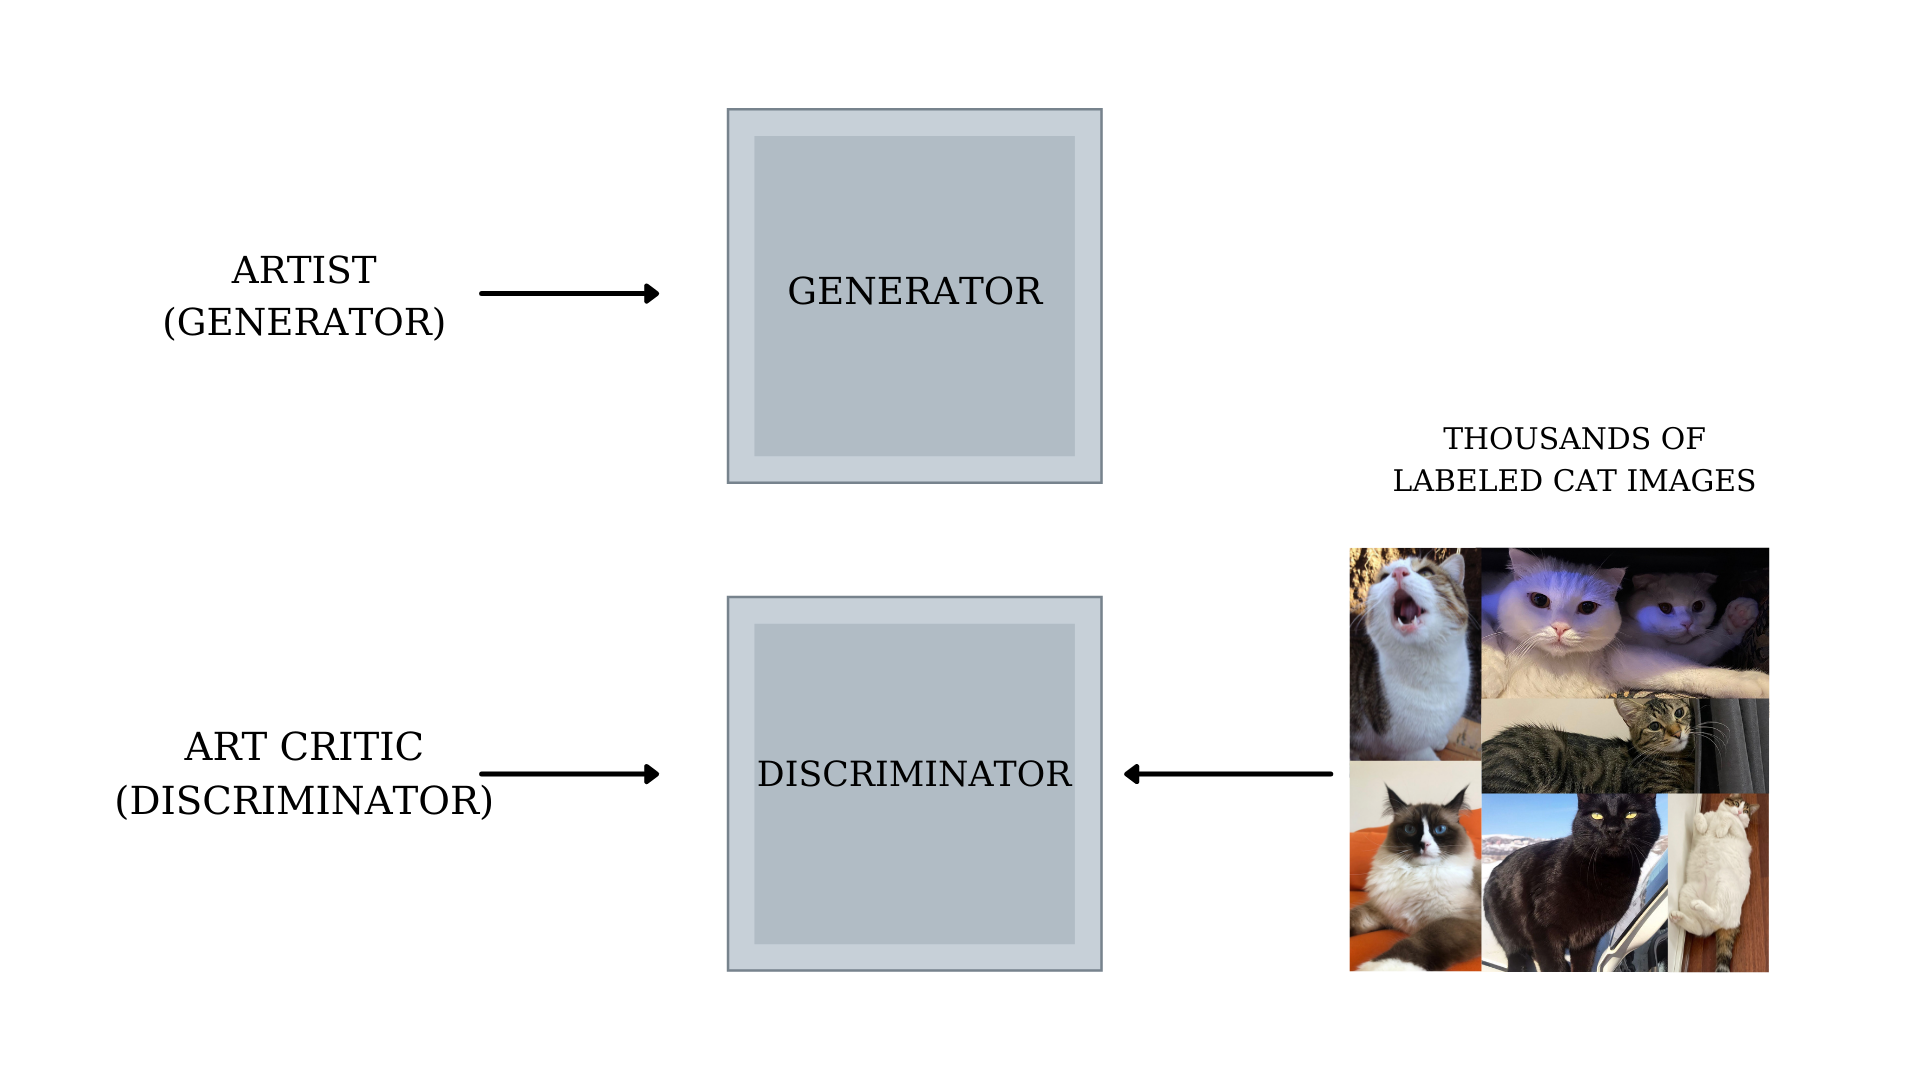



## STEP 1: Installing required libraries


In [5]:
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.7.0


In [6]:
def show(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

## STEP 2: Loading the data and performing the preprocessing

In this study, we will use the [Fashion MNIST](https://www.kaggle.com/zalando-research/fashionmnist) dataset and in this dataset, we will use a wide variety of shoes, boots, sandals, t-shirts, coats, bandanas, etc. Labeled samples of textile products are included.

In [7]:
# We are downloading the Fashion MNIST dataset via keras.
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0

4431872/4422102 [==============================] - 0s 0us/step


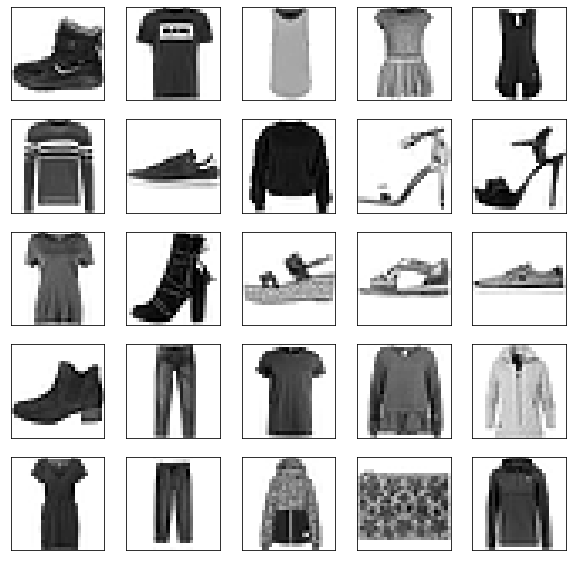

In [8]:
# Let's print 25 samples of 10x10 pixels from the dataset to the screen and see what it looks like.
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
plt.show()

## STEP 3: Creating training data and groups

In [9]:
batch_size = 32
# This dataset fills a buffer with buffer_size elements, then randomly samples the selected elements, replacing them with new elements.
dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(1000)
# This aggregates the consecutive elements of the dataset.
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

## STEP 4: Creating the generator network for DCGAN

---


In the equation, D is defined as the discriminator and G as the generator, and the contention between them is expressed. Actually, this is a basic *game theory* approach.

Here we get a structure of images starting from random noise by performing deconvolution. Increasingly, we enable this generator to produce similar to real images through the equation below.

![GAN Denklemi](https://i.hizliresim.com/IknKWJ.png)

This equation represents the structure in the image below:

![GAN Anlama](https://i.hizliresim.com/mYldwo.gif)

Resource: [Play with Generative Adversarial Networks (GANs) in your browser!](https://poloclub.github.io/ganlab/)

---

GAN models are generally used in **SELU** and **TANH** interlayers as activation functions. In output layers, **SIGMOID** or **SOFTMAX** are preferred.

Oral and written explanations about activation functions you can see **[here](https://medium.com/@ayyucekizrak/derin-%C3%B6%C4%9Frenme-i%C3%A7in-aktivasyon-fonksiyonlar%C4%B1n%C4%B1n-kar%C5%9F%C4%B1la%C5%9Ft%C4%B1r%C4%B1lmas%C4%B1-cee17fd1d9cd)**.

---
DCGAN, on the other hand, consists of two networks, Convolution and Deconvolution. Because the Generator and Discriminator networks are convolutional, they are called *Deep Convolutional Generative Adversarial Networks*.


[DCGAN](https://arxiv.org/pdf/1511.06434.pdf)

![DCGAN](https://i.hizliresim.com/XnsRnK.jpg)

[Resource](https://arxiv.org/pdf/1511.06434.pdf)

---

In a GAN Generator where the generator and discriminator networks are deep convolutional networks, the size enlargement of the images is done using the `Conv2DTranspose` layer.

The generator network is a tensor with random Gaussian noise as shown in the figure. We start with an input of size `7 * 7* 128`. With this test two-dimensional convolution layers, we try to obtain a **synthetic** image by reducing the number of channels in each layer and increasing the width and height. The generative network is trained to falsify the discriminant network, minimizing loss throughout the training, producing more realistic visuals.


In [10]:
# Convolutional Network at the GENERATOR LAYER
num_features = 100 #  number of attributes

# We start according to the number of features we give the input value. We are using the Conv2DTranpose version.
generator = keras.models.Sequential([
    keras.layers.Dense(7 * 7 * 128, input_shape=[num_features]),
    keras.layers.Reshape([7, 7, 128]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64, (5,5), (2,2), padding="same", activation="selu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(1, (5,5), (2,2), padding="same", activation="tanh"),
])

* While modeling GAN, when choosing hidden space samples, normal distribution (Gaussian Distribution) is used instead of uniform distribution.
* Stochastic increases durability. Because GAN training results are in a dynamic balance, GANs are prone to stalemate in all directions. Randomness helps prevent this from happening during training.

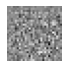

In [11]:
noise = tf.random.normal(shape=[1, num_features])
generated_images = generator(noise, training=False)
show(generated_images, 1)

## STEP 5: Creating the discriminator network for DCGAN

The discriminator network takes an image as input—this can be synthetic or real—and guesses whether the image comes from the training dataset or whether the generative network knits. This part of the model consists of a familiar convolutional neural network and works as a classifier. There are two convolutional two layers of activation functions, starting from the image and progressing to all the link layers. In this distinctive model, **LeakyReLU** or **ReLU** is preferred as the activation function.

In [12]:
discriminator = keras.models.Sequential([
    keras.layers.Conv2D(64, (5,5), (2,2), padding="same", input_shape=[28, 28, 1]),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    keras.layers.Conv2D(128, (5,5), (2,2), padding="same"),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation='sigmoid')
])

In [13]:
# Produced a distinctive value below 50% for the produced image for the first step
decision = discriminator(generated_images)
print(decision)

tf.Tensor([[0.49971497]], shape=(1, 1), dtype=float32)


## STEP 6: Compiling Your Deep Convolutional Generator Adversarial Network (DCGAN)

Now your model will be able to classify the points of the hidden space as "real" or "false". The differential network will be updated with the weights of the generating network. So we need to set the discriminator network to not be trained. This is accomplished with the following `discriminator.trainable=False` that I am talking about.

* If we set the discriminator to be trainable i.e. if it updates its own weights during training, it will always be trained to say "real" and this is something we don't want if we are trying to generate synthetic data.

We prefer our loss function and optimization algorithm. We are preparing the generator and distinctive models for the competition to provide balance :)

* If the attenuation of the adversarial network becomes too high during training, you will find that the loss of the discriminator network approaches zero. This means that the generator dominates the network, and the generator is not successful in generating synthetic data as we would like. To avoid this, you can try to reduce the learning rate of the discriminator model.


In [14]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan = keras.models.Sequential([generator, discriminator])
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

## STEP 7: Visualizing the training processes
In this step, we define the progress steps. During the training, we want to print the results we obtained from the generator model in each epoch on the screen and save the image we printed on each screen. Because at the end we can visualize the improvement in the results of the epochs during the training.



In [15]:
from IPython import display
from tqdm import tqdm
seed = tf.random.normal(shape=[batch_size, 100])

In [16]:
from tqdm import tqdm
def train_dcgan(gan, dataset, batch_size, num_features, epochs=5):
    generator, discriminator = gan.layers
    for epoch in tqdm(range(epochs)):
        print("Epoch {}/{}".format(epoch + 1, epochs))
        for X_batch in dataset:
            noise = tf.random.normal(shape=[batch_size, num_features])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)
            noise = tf.random.normal(shape=[batch_size, num_features])
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)
            # Let's print the generated images to the screen and save them to the file
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)
        
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

In [17]:
## Resource: https://www.tensorflow.org/tutorials/generative/dcgan#create_a_gif
def generate_and_save_images(model, epoch, test_input):
  # 'Training' is set to False.
  # So all layers work in (batchnorm) mode.
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(10,10))

  for i in range(25):
      plt.subplot(5, 5, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='binary')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

## STEP 8: Training DCGAN

We perform the training process according to the gan, dataset, batch_size, num_features and epoch values ​​that we defined in this step and print the results to the screen.

In [18]:
# Performing resizing for training
x_train_dcgan = x_train.reshape(-1, 28, 28, 1) * 2. - 1.

In [19]:
#Specifying batch size and shuffle properties
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(x_train_dcgan)
dataset = dataset.shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

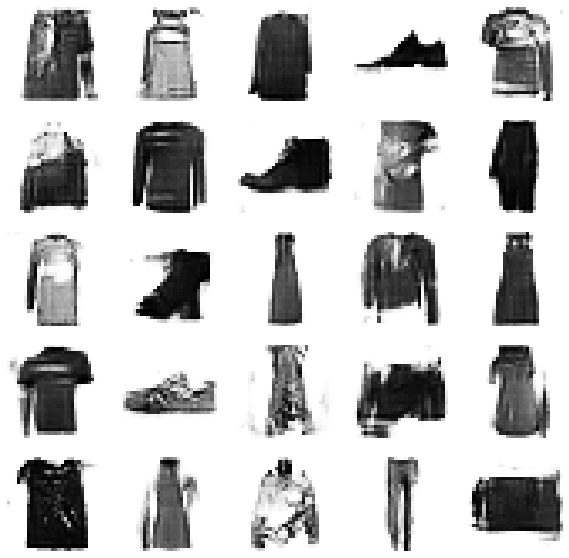

CPU times: user 2h 45min 46s, sys: 5min 53s, total: 2h 51min 39s
Wall time: 1h 34min 38s


In [20]:
# Training gan model with batch_size size and number of attributes determined for the defined dataset
# 10 will be epochs, you can observe the development of the model by changing the number of epochs.
%%time 
train_dcgan(gan, dataset, batch_size, num_features, epochs=10)

## STEP 9: Creation of synthetic images with DCGAN

In this step, we visualize the results generated by the generating network by making use of the 'show' function that we defined at the beginning.

After saving the results for each epoch in .png format, we convert it to .gif format, print it on the screen and save it to the file.

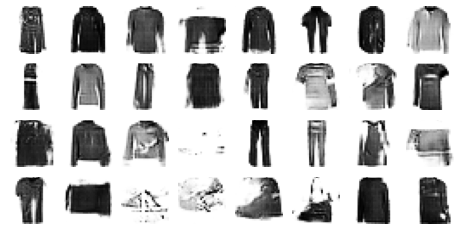

In [21]:
noise = tf.random.normal(shape=[batch_size, num_features])
generated_images = generator(noise)
show(generated_images, 8)

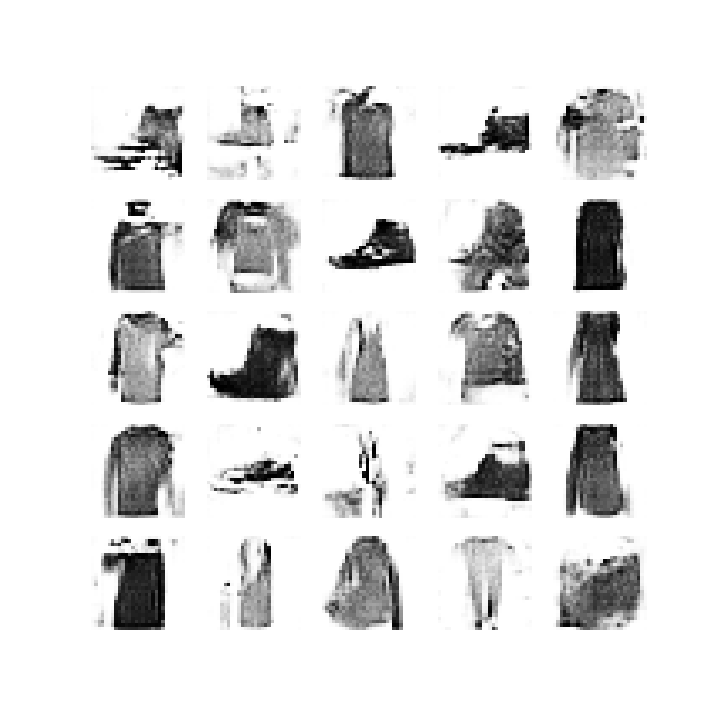

In [22]:
# Run this part to show the results as GIF.
## Source: https://www.tensorflow.org/tutorials/generative/dcgan#create_a_gif
import imageio
import glob

anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

from IPython.display import Image
Image(open(anim_file,'rb').read())

### CONCLUSION

We performed synthetic data generation from the Fashion Mnist dataset, known to most people working on the image, using deep convolutional generative adversarial networks (DCGAN). In cases where you need more data of similar nature, you can expand your dataset in this way, since collecting data is time consuming and costly. You can layer up the generator and discriminator networks as appropriate to improve your DCGAN results (models were not built too deep for this study).


---

### RESOURCES:

*   [Coursera Course: Generate Synthetic Images with DCGANs in Keras](https://www.coursera.org/projects/generative-adversarial-networks-keras)
*   [Generative Adversarial Nets](https://arxiv.org/pdf/1406.2661.pdf)
*   [Play with Generative Adversarial Networks (GANs) in your browser!](https://poloclub.github.io/ganlab/)






In [ ]:
%%shell
jupyter nbconvert --to html /content/DCGAN_LAST.ipynb

[NbConvertApp] Converting notebook /content/DCGAN_LAST.ipynb to html
[NbConvertApp] Writing 3068493 bytes to /content/DCGAN_LAST.html
